Removing Highly Correlated Features

In [183]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

file_path = "../data/processed/cleaned_weather_data.csv"
df = pd.read_csv(file_path)

In [184]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

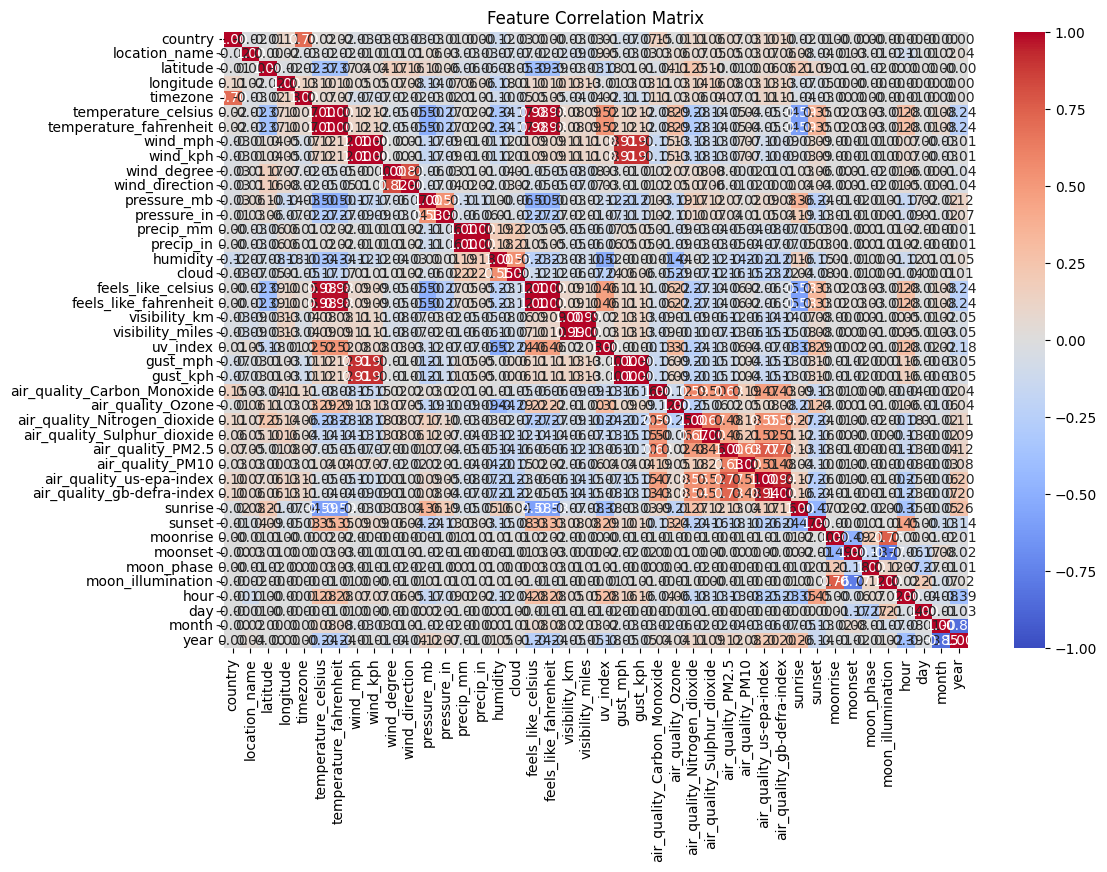

In [185]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

In [186]:
high_corr_pairs = set()
threshold = 0.95
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.add((col1, col2))

In [187]:
print("highly correlated feature pairs:", high_corr_pairs)

highly correlated feature pairs: {('precip_in', 'precip_mm'), ('feels_like_celsius', 'temperature_fahrenheit'), ('temperature_fahrenheit', 'temperature_celsius'), ('wind_kph', 'wind_mph'), ('feels_like_celsius', 'temperature_celsius'), ('feels_like_fahrenheit', 'temperature_fahrenheit'), ('feels_like_fahrenheit', 'feels_like_celsius'), ('visibility_miles', 'visibility_km'), ('feels_like_fahrenheit', 'temperature_celsius'), ('gust_kph', 'gust_mph')}


In [188]:
features_to_drop = [
    "temperature_fahrenheit",
    "gust_mph",
    "feels_like_fahrenheit",
    "visibility_miles",
    "precip_in",
    "wind_mph"
]

df.drop(columns=features_to_drop, inplace= True)

creating new features(feature extraction)

In [189]:
df['temp_diff'] = df['temperature_celsius'] - df['feels_like_celsius']

In [190]:
df['wind_power'] = df['wind_kph'] * df['gust_kph']

The impact of pollutants on human health is often represented by their Air Quality Index (AQI) factors. Based on various studies and AQI standards (e.g., EPA, WHO), approximate weightings are:
```
|Pollutant	|Health Impact Weight (Approximate)|
|PM2.5 (Fine Particulate Matter)	|0.4|
|PM10 (Coarse Particulate Matter)	|0.2|
|Ozone (O3)	|0.15|
|Nitrogen Dioxide (NO2)	|0.1|
|Sulfur Dioxide (SO2)	|0.1|
|Carbon Monoxide (CO)	|0.05|
```

In [191]:
# Define weights based on air quality impact
weights = {
    'air_quality_PM2.5': 0.4,
    'air_quality_PM10': 0.2,
    'air_quality_Ozone': 0.15,
    'air_quality_Nitrogen_dioxide': 0.1,
    'air_quality_Sulphur_dioxide': 0.1,
    'air_quality_Carbon_Monoxide': 0.05
}


In [192]:
# Calculate the weighted air quality risk factor
df['air_quality_risk'] = sum(df[col] * weight for col, weight in weights.items())

Since weather patterns are influenced by time-based factors, we should extract temporal features to help our model capture trends effectively.

In [193]:
# Convert 'hour', 'day', 'month' into cyclic features using sin/cos transformations
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

Lag features allow the model to learn from past values, capturing trends and seasonality.

In [194]:
# Lag features for temperature, humidity, and precipitation (1-day, 7-day lags)
lag_features = ['temperature_celsius', 'humidity', 'precip_mm']
for feature in lag_features:
    df[f'{feature}_lag_1'] = df[feature].shift(1)  # Previous day
    df[f'{feature}_lag_7'] = df[feature].shift(7)  # 7-day lag

In [195]:
print(df.isnull().sum())

country                      0
location_name                0
latitude                     0
longitude                    0
timezone                     0
                            ..
temperature_celsius_lag_7    7
humidity_lag_1               1
humidity_lag_7               7
precip_mm_lag_1              1
precip_mm_lag_7              7
Length: 98, dtype: int64


In [196]:
df.dropna(inplace=True)

We can leverage latitude, longitude, and elevation to extract useful patterns.

Temperature and climate vary with distance from the equator.

In [197]:
df['distance_from_equator'] = abs(df['latitude'])


compute correlation of new features

In [198]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix_new = numeric_df.corr()

In [199]:
# Set a threshold (e.g., > 0.9 or < -0.9)
threshold = 0.9
high_corr_pairs = [
    (col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns
    if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold
]

In [200]:
print("Highly correlated feature pairs:", high_corr_pairs)

Highly correlated feature pairs: [('temperature_celsius', 'temperature_fahrenheit'), ('temperature_celsius', 'feels_like_celsius'), ('temperature_celsius', 'feels_like_fahrenheit'), ('temperature_fahrenheit', 'temperature_celsius'), ('temperature_fahrenheit', 'feels_like_celsius'), ('temperature_fahrenheit', 'feels_like_fahrenheit'), ('wind_mph', 'wind_kph'), ('wind_mph', 'gust_mph'), ('wind_mph', 'gust_kph'), ('wind_kph', 'wind_mph'), ('wind_kph', 'gust_mph'), ('wind_kph', 'gust_kph'), ('precip_mm', 'precip_in'), ('precip_in', 'precip_mm'), ('feels_like_celsius', 'temperature_celsius'), ('feels_like_celsius', 'temperature_fahrenheit'), ('feels_like_celsius', 'feels_like_fahrenheit'), ('feels_like_fahrenheit', 'temperature_celsius'), ('feels_like_fahrenheit', 'temperature_fahrenheit'), ('feels_like_fahrenheit', 'feels_like_celsius'), ('visibility_km', 'visibility_miles'), ('visibility_miles', 'visibility_km'), ('gust_mph', 'wind_mph'), ('gust_mph', 'wind_kph'), ('gust_mph', 'gust_kph')

In [201]:
# Drop redundant highly correlated features
columns_to_drop = [
    'temperature_fahrenheit', 'wind_mph', 'gust_mph', 
    'precip_in', 'visibility_miles', 'feels_like_fahrenheit', 
    'air_quality_gb-defra-index'
]

# Only drop columns that exist in the DataFrame
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


In [202]:
print(df.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated', 'temperature_celsius', 'wind_kph', 'wind_degree',
       'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'humidity',
       'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph',
       'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
       'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
       'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index',
       'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase',
       'moon_illumination', 'condition_text_Blowing snow',
       'condition_text_Clear', 'condition_text_Cloudy', 'condition_text_Fog',
       'condition_text_Freezing drizzle', 'condition_text_Freezing fog',
       'condition_text_Heavy rain', 'condition_text_Heavy rain at times',
       'condition_text_Heavy snow', 'condition_text_Light drizzle',
       'condition_text_Light freezing rain', 'condition_text_Light rain',


In [203]:
print(df.head())

     country  location_name  latitude  longitude  timezone  \
7   0.005147       0.005147     40.18      44.51  0.005147   
8   0.005131       0.005131     48.20      16.37  0.005131   
9   0.005131       0.005131     40.40      49.88  0.005131   
10  0.005067       0.005067     25.08     -77.35  0.005067   
11  0.005147       0.005147     26.24      50.58  0.005147   

           last_updated  temperature_celsius  wind_kph  wind_degree  \
7   2024-05-16 08:45:00                 19.0       6.8          140   
8   2024-05-16 08:45:00                 16.0      20.2          110   
9   2024-05-16 08:45:00                 17.0       6.8           20   
10  2024-05-16 08:45:00                 27.0      25.9          180   
11  2024-05-16 08:45:00                 36.0      22.0          140   

    wind_direction  ...   day_cos  month_sin  month_cos  \
7            135.0  ... -0.994869        0.5  -0.866025   
8            112.5  ... -0.994869        0.5  -0.866025   
9             22.5  ...

In [204]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numerical_features)


['country', 'location_name', 'latitude', 'longitude', 'timezone', 'temperature_celsius', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination', 'hour', 'day', 'month', 'year', 'temp_diff', 'wind_power', 'air_quality_risk', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'temperature_celsius_lag_1', 'temperature_celsius_lag_7', 'humidity_lag_1', 'humidity_lag_7', 'precip_mm_lag_1', 'precip_mm_lag_7', 'distance_from_equator']


In [205]:
# Drop categorical and datetime-like features
excluded_features = ['country', 'location_name','last_updated', 'timezone', 'wind_direction', 
                     'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'weather_group']

# Select only numerical features
numerical_features = [col for col in df.columns if col not in excluded_features]

print(numerical_features) 

['latitude', 'longitude', 'temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'moon_illumination', 'condition_text_Blowing snow', 'condition_text_Clear', 'condition_text_Cloudy', 'condition_text_Fog', 'condition_text_Freezing drizzle', 'condition_text_Freezing fog', 'condition_text_Heavy rain', 'condition_text_Heavy rain at times', 'condition_text_Heavy snow', 'condition_text_Light drizzle', 'condition_text_Light freezing rain', 'condition_text_Light rain', 'condition_text_Light rain shower', 'condition_text_Light sleet', 'condition_text_Light sleet showers', 'condition_text_Light snow', 'condition_text_Light snow showers', 'condition_text_Mist', 'condition_text_Moderate or heavy ra

In [206]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [207]:
# Scale only the corrected numerical features
df_scaled = df.copy()
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])


In [208]:
# Save the scaler for future use
import joblib
joblib.dump(scaler, '../artifact/standard_scaler.pkl')

['../artifact/standard_scaler.pkl']

In [209]:
print(df_scaled.head())

     country  location_name  latitude  longitude  timezone  \
7   0.005147       0.005147  0.861119   0.339700  0.005147   
8   0.005131       0.005131  1.188921  -0.087730  0.005131   
9   0.005131       0.005131  0.870111   0.421267  0.005131   
10  0.005067       0.005067  0.243935  -1.511279  0.005067   
11  0.005147       0.005147  0.291348   0.431899  0.005147   

           last_updated  temperature_celsius  wind_kph  wind_degree  \
7   2024-05-16 08:45:00            -0.327363 -0.775276    -0.278225   
8   2024-05-16 08:45:00            -0.640468  0.845118    -0.567421   
9   2024-05-16 08:45:00            -0.536100 -0.775276    -1.435008   
10  2024-05-16 08:45:00             0.507582  1.534389     0.107369   
11  2024-05-16 08:45:00             1.446895  1.062782    -0.278225   

    wind_direction  ...   day_cos  month_sin  month_cos  \
7            135.0  ... -1.381983    0.86859  -1.340544   
8            112.5  ... -1.381983    0.86859  -1.340544   
9             22.5  ...

In [210]:
numerical_features = df_scaled.select_dtypes(include=['number']).columns.tolist()
print(f"Total numerical features: {len(numerical_features)}")
print(numerical_features)


Total numerical features: 97
['country', 'location_name', 'latitude', 'longitude', 'timezone', 'temperature_celsius', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination', 'condition_text_Blowing snow', 'condition_text_Clear', 'condition_text_Cloudy', 'condition_text_Fog', 'condition_text_Freezing drizzle', 'condition_text_Freezing fog', 'condition_text_Heavy rain', 'condition_text_Heavy rain at times', 'condition_text_Heavy snow', 'condition_text_Light drizzle', 'condition_text_Light freezing rain', 'condition_text_Light rain', 'condition_text_Light rain shower', 'condition_text_Light sleet', 'condition_text_Li

In [211]:
all_columns = df_scaled.columns.tolist()
missing_features = set(all_columns) - set(numerical_features)

print(f"Total dataset columns: {len(all_columns)}")
print(f"Numerical features detected: {len(numerical_features)}")
print(f"Missing numerical features: {missing_features}")


Total dataset columns: 98
Numerical features detected: 97
Missing numerical features: {'last_updated'}


In [212]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58218 entries, 7 to 58224
Data columns (total 98 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   country                                                     58218 non-null  float64
 1   location_name                                               58218 non-null  float64
 2   latitude                                                    58218 non-null  float64
 3   longitude                                                   58218 non-null  float64
 4   timezone                                                    58218 non-null  float64
 5   last_updated                                                58218 non-null  object 
 6   temperature_celsius                                         58218 non-null  float64
 7   wind_kph                                                    58218 non-null  float64
 8   w

In [213]:
import os

processed_path = "../data/processed/feature_eng_weather_data.csv"

os.makedirs(os.path.dirname(processed_path), exist_ok=True)

df_scaled.to_csv(processed_path, index=False)

print(f"Cleaned dataset saved at: {processed_path}")


Cleaned dataset saved at: ../data/processed/feature_eng_weather_data.csv
